In [3]:
import zipfile
import pandas as pd

# Path to your zip archive
zip_path = r"C:\Users\as370\Downloads\archive (19).zip"

with zipfile.ZipFile(zip_path, 'r') as z:
    print("Files inside zip:", z.namelist())


Files inside zip: ['Unemployment in India.csv', 'Unemployment_Rate_upto_11_2020.csv']


In [5]:
# Step 2: Load both CSVs into pandas DataFrames
with zipfile.ZipFile(zip_path, 'r') as z:
    df1 = pd.read_csv(z.open(z.namelist()[0]))
    df2 = pd.read_csv(z.open(z.namelist()[1]))

print("First dataset preview:")
print(df1.head())

print("\nSecond dataset preview:")
print(df2.head())


First dataset preview:
           Region         Date  Frequency   Estimated Unemployment Rate (%)  \
0  Andhra Pradesh   31-05-2019    Monthly                              3.65   
1  Andhra Pradesh   30-06-2019    Monthly                              3.05   
2  Andhra Pradesh   31-07-2019    Monthly                              3.75   
3  Andhra Pradesh   31-08-2019    Monthly                              3.32   
4  Andhra Pradesh   30-09-2019    Monthly                              5.17   

    Estimated Employed   Estimated Labour Participation Rate (%)   Area  
0           11999139.0                                     43.24  Rural  
1           11755881.0                                     42.05  Rural  
2           12086707.0                                     43.50  Rural  
3           12285693.0                                     43.97  Rural  
4           12256762.0                                     44.68  Rural  

Second dataset preview:
           Region         Date  F

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
print("df1 columns:", df1.columns)
print("df2 columns:", df2.columns)

df1 columns: Index(['Region', ' Date', ' Frequency', ' Estimated Unemployment Rate (%)',
       ' Estimated Employed', ' Estimated Labour Participation Rate (%)',
       'Area'],
      dtype='object')
df2 columns: Index(['Region', ' Date', ' Frequency', ' Estimated Unemployment Rate (%)',
       ' Estimated Employed', ' Estimated Labour Participation Rate (%)',
       'Region.1', 'longitude', 'latitude'],
      dtype='object')


In [11]:
df1.columns = df1.columns.str.strip().str.lower()
df2.columns = df2.columns.str.strip().str.lower()

In [13]:
# Convert 'Date' column to datetime (adjust column name as per your dataset)
date_col1 = [c for c in df1.columns if "date" in c][0]
date_col2 = [c for c in df2.columns if "date" in c][0]

df1[date_col1] = pd.to_datetime(df1[date_col1], dayfirst=True, errors="coerce")
df2[date_col2] = pd.to_datetime(df2[date_col2], dayfirst=True, errors="coerce")

In [15]:
# Standardize unemployment column
urate_col1 = [c for c in df1.columns if "unemployment" in c][0]
urate_col2 = [c for c in df2.columns if "unemployment" in c][0]

df1.rename(columns={date_col1:"Date", urate_col1:"UnemploymentRate"}, inplace=True)
df2.rename(columns={date_col2:"Date", urate_col2:"UnemploymentRate"}, inplace=True)

In [17]:
df = pd.concat([df1, df2], ignore_index=True)
df = df.dropna(subset=["UnemploymentRate"]).sort_values("Date").reset_index(drop=True)

print("\nCombined dataset shape:", df.shape)
print(df.head())


Combined dataset shape: (1007, 10)
             region       Date frequency  UnemploymentRate  \
0    Andhra Pradesh 2019-05-31   Monthly              3.65   
1         Jharkhand 2019-05-31   Monthly              7.11   
2   Jammu & Kashmir 2019-05-31   Monthly             12.78   
3    Madhya Pradesh 2019-05-31   Monthly              3.91   
4  Himachal Pradesh 2019-05-31   Monthly             13.68   

   estimated employed  estimated labour participation rate (%)   area  \
0          11999139.0                                    43.24  Rural   
1           7035766.0                                    39.04  Rural   
2           2495186.0                                    40.57  Rural   
3           6692720.0                                    38.96  Urban   
4           2045760.0                                    44.23  Rural   

  region.1  longitude  latitude  
0      NaN        NaN       NaN  
1      NaN        NaN       NaN  
2      NaN        NaN       NaN  
3      NaN      

## Exploratory analysis

#### National monthly average unemployment

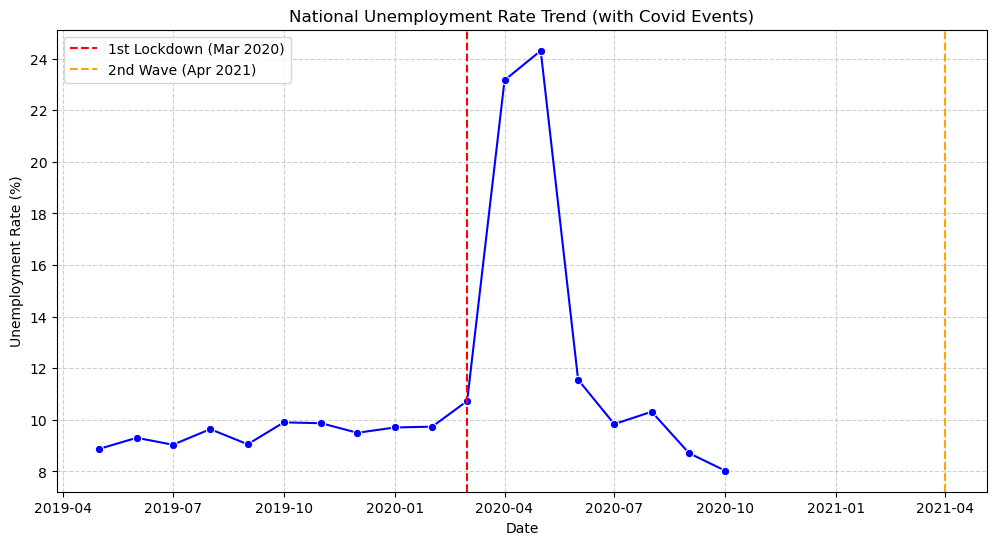

In [38]:
monthly = df.groupby(df["Date"].dt.to_period("M"))["UnemploymentRate"].mean().reset_index()
monthly["Date"] = monthly["Date"].dt.to_timestamp()

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly, x="Date", y="UnemploymentRate", marker="o", color="blue")

# Add vertical lines for major Covid events
plt.axvline(pd.to_datetime("2020-03"), color="red", linestyle="--", label="1st Lockdown (Mar 2020)")
plt.axvline(pd.to_datetime("2021-04"), color="orange", linestyle="--", label="2nd Wave (Apr 2021)")

# Title & Labels
plt.title("National Unemployment Rate Trend (with Covid Events)")
plt.xlabel("Date")
plt.ylabel("Unemployment Rate (%)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

#### Covid impact analysis

In [27]:
periods = {
    "Pre-Covid": ("2019-01-01","2020-02-29"),
    "Lockdown (2020)": ("2020-03-01","2020-06-30"),
    "Recovery (H2 2020)": ("2020-07-01","2020-12-31"),
    "2nd Wave (Q2 2021)": ("2021-04-01","2021-06-30"),
    "Post-2021": ("2021-07-01","2022-12-31")
}

impact = {}
for pname, (start, end) in periods.items():
    mask = (df["Date"]>=pd.to_datetime(start)) & (df["Date"]<=pd.to_datetime(end))
    impact[pname] = df.loc[mask, "UnemploymentRate"].mean()

impact_df = pd.DataFrame(list(impact.items()), columns=["Period","Avg_UnemploymentRate"])
print("\nCovid Impact on Unemployment:")
print(impact_df)



Covid Impact on Unemployment:
               Period  Avg_UnemploymentRate
0           Pre-Covid              9.484932
1     Lockdown (2020)             17.419421
2  Recovery (H2 2020)              9.220000
3  2nd Wave (Q2 2021)                   NaN
4           Post-2021                   NaN


#### Seasonality

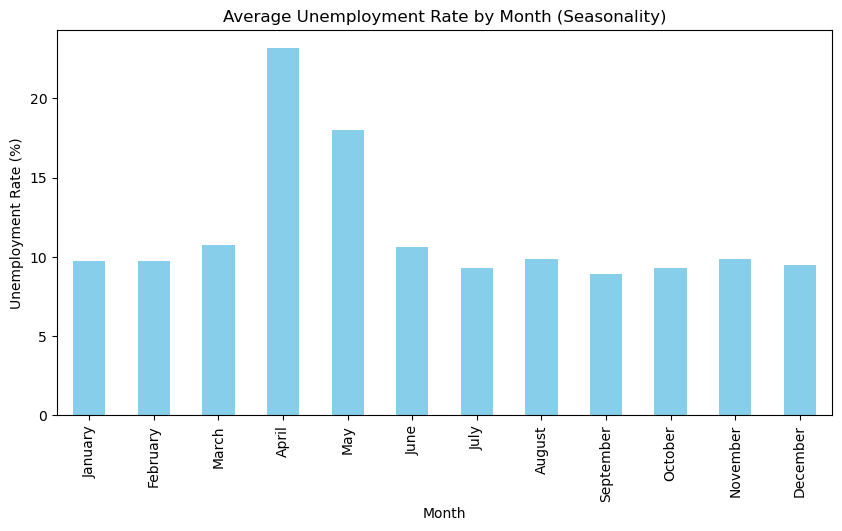

In [30]:
df["Month"] = df["Date"].dt.month_name()
seasonality = df.groupby("Month")["UnemploymentRate"].mean().reindex(
    ["January","February","March","April","May","June","July","August","September","October","November","December"]
)

plt.figure(figsize=(10,5))
seasonality.plot(kind="bar", color="skyblue")
plt.title("Average Unemployment Rate by Month (Seasonality)")
plt.ylabel("Unemployment Rate (%)")
plt.show()


 #### Insights

In [35]:
print("\n-- Insights --")
print(f"Peak unemployment during lockdown: {impact['Lockdown (2020)']:.2f}%")
print(f"Unemployment dropped to {impact['Recovery (H2 2020)']:.2f}% during recovery phase.")
print(f"Seasonality shows highest unemployment in {seasonality.idxmax()} ({seasonality.max():.2f}%).")
print(f"Lowest unemployment in {seasonality.idxmin()} ({seasonality.min():.2f}%).")


-- Insights --
Peak unemployment during lockdown: 17.42%
Unemployment dropped to 9.22% during recovery phase.
Seasonality shows highest unemployment in April (23.17%).
Lowest unemployment in September (8.93%).
